In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import scipy.optimize as opt
import scipy.stats as stats
from tqdm import tqdm
from scipy import signal
import scipy.fft
from scipy import stats

plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',  # Use a serif font
    'font.size': 10,         # Adjust the font size to match your LaTeX document
})

# For a two-column document, set the figure width to be within the column width
column_width_pt = 246  # Adjust this based on your document's column width
inches_per_pt = 1/72.27
golden_ratio = (5**0.5 - 1) / 2  # Golden ratio to make the figure aesthetically pleasing

fig_width = column_width_pt * inches_per_pt
fig_height = fig_width * golden_ratio



plt.style.use('default')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "lines.linewidth" : 0.75,
          'xtick.minor.width' : 0.5,
          'xtick.major.width' : 0.5,
          'ytick.minor.width' : 0.5,
          'ytick.major.width' : 0.5,
          'axes.spines.top' : False,
          'axes.spines.right' : False,
          'axes.linewidth' : 0.5}
plt.rcParams.update(params)
plt.rc('figure', figsize=(fig_width, fig_height))
plt.rc('legend', frameon=False)

In [3]:
def autoCorrelation(x, connected = True):
  '''
  Computes the self-correlation of the time series x(t) of a scalar variable. Averaging over initial values t_0. X is an N by M array which contains the N points
  of M realizations of the time series. The N points are all spaced by a time Delta t so that t_i = i*Delta t
  Connected: Is used to indicate if you want to compute the connected correlation or not. Set to True by default
  method: Method that scipy uses to compute the correlation. Set to fast fourier transform by default.
  '''
  x = np.asarray(x)
  (N,M) = np.shape(x)
  fourierTransform2 = np.zeros((2*N,M),dtype=np.complex128)
  if connected:
    c = np.mean(x,axis=0)
    for el in range(M):
      x[:,el] = x[:,el] - c[el]
  fourierTransform = scipy.fft.fft(x,2*N,axis=0)
  corr = scipy.fft.ifft(np.power(np.abs(fourierTransform[:N,:]),2),2*N,axis=0)
  factor = np.array([1/(N-i+1) for i in range(1,N+1)])
  corr = corr[:N,:]
  for n in range(M):
    corr[:,n] = corr[:,n]*factor
  return np.mean(np.real(corr),axis=1)

def integralCorrTime(corr,alpha):
  '''
    Computes the integral correlation time tau of a correlation corr (normalized and connected). Corr is a 1D array of N elements. The integral correlation time is computed
    using the equation tau = int_0^(alpha tau) c(t)dt. Usually alpha = 3 is enough but it can be computed as a function of alpha
    corr: Connected and normalized correlation function
    alpha: Upper bound for the integral
  '''
  for M in range(1,len(corr)):
    sum = np.sum(corr[:(M+1)]/corr[0])
    if alpha*sum < M:
      return sum
  raise Exception("No suitable value found")


def corrTime(x,t,tau):
  f = np.sum((x*np.sinc(t/(np.pi*tau))/tau))*0.025-np.pi/4
  return f

def CorrT0(x,t0, connected = False):
  if connected:
    mean = np.mean(x)
    delX = x-mean
  else:
    delX = x
  corr = delX[t0]*delX[t0:]
  return corr

In [4]:
root_dir = "../ConfinedDataReferee"
extFieldIsmData_dir = root_dir+"/ExternalFieldISM_Data"
infoIsm_File = root_dir +"/ExtFieldISM_Info.csv"
extFieldISMProcessedData_dir = root_dir + "/ExtFieldISM_ProcessedData"
extFieldISMImages_dir = root_dir+"/ExtFieldISM_Images"

def filesFromIndex(idx):
    idxString = f'{idx:03d}'+'.csv'
    return (extFieldIsmData_dir+"/Pos"+idxString,extFieldIsmData_dir+"/Vel"+idxString,extFieldIsmData_dir+"/Spin"+idxString)

extFieldISM_Info = pd.read_csv(infoIsm_File)
fields = extFieldISM_Info.Field.unique()
inertias = extFieldISM_Info.Inertia.unique()
indicesPerField = []
for f in fields:
    indicesPerField.append(list(extFieldISM_Info[extFieldISM_Info.Field == f].index))

In [5]:
try:
    autoCorrelationPos = np.load(extFieldISMProcessedData_dir+"/autoCorrelationPos.npy")
    autoCorrelationVel = np.load(extFieldISMProcessedData_dir+"/autoCorrelationVel.npy")
    autoCorrelationSpin = np.load(extFieldISMProcessedData_dir+"/autoCorrelationSpin.npy")
except FileNotFoundError:
    autoCorrelationPos = np.zeros((int(600000/25)-3000,len(inertias),len(fields)))
    autoCorrelationVel = np.zeros((int(600000/25)-3000,len(inertias),len(fields)))
    autoCorrelationSpin = np.zeros((int(600000/25)-3000,len(inertias),len(fields)))
    for chi in range(len(inertias)):
        print(chi)
        for f in range(len(fields)):
            files = filesFromIndex(indicesPerField[f][chi])
            posTimeSeries = np.loadtxt(files[0],delimiter =',', skiprows = 1)
            xSeries = posTimeSeries[3000:,::2]
            ySeries = posTimeSeries[3000:,1::2]
            autoCorrelationPos[:,chi,f] = autoCorrelation(xSeries)+autoCorrelation(ySeries)

            velTimeSeries = np.loadtxt(files[1],delimiter=',',skiprows = 1)
            velxSeries = velTimeSeries[3000:,::2]
            velySeries = velTimeSeries[3000:,1::2]
            autoCorrelationVel[:,chi,f] = autoCorrelation(velxSeries)+autoCorrelation(velySeries)

            spinTimeSeries = np.loadtxt(files[2],delimiter = ',',skiprows = 1)
            autoCorrelationSpin[:,chi,f] = autoCorrelation(spinTimeSeries[3000:,:])
    np.save(extFieldISMProcessedData_dir+"/autoCorrelationPos.npy",autoCorrelationPos)
    np.save(extFieldISMProcessedData_dir+"/autoCorrelationVel.npy",autoCorrelationVel)
    np.save(extFieldISMProcessedData_dir+"/autoCorrelationSpin.npy",autoCorrelationSpin)

try:
    msdIsm = np.load(extFieldISMProcessedData_dir+"/msdISM.npy")
    radiisIsm = np.load(extFieldISMProcessedData_dir+"/radiisISM.npy")
    dsqIsm = np.load(extFieldISMProcessedData_dir+"/dsqISM.npy")

except FileNotFoundError:
    msdIsm = np.zeros((int(600000/25)-3000,len(inertias),len(fields)))
    radiisIsm = np.zeros((int(600000/25),len(inertias),len(fields)))
    dsqIsm = np.zeros((len(inertias),len(fields)))
    for nfield in range(len(fields)):
        print(nfield)
        for idx in range(15):
            filePos = filesFromIndex(indicesPerField[nfield][idx])[0]
            timeSeries = np.loadtxt(filePos,delimiter = ',', skiprows = 1)
            posX = timeSeries[:,::2]
            posY = timeSeries[:,1::2]
            r0 = np.sqrt(np.power(posX,2)+np.power(posY,2))
            radiisIsm[:,idx,nfield] = np.mean(r0,axis = 1) 
            delPosX = posX[3000:,:]-posX[3000,:]
            delPosY = posY[3000:,:]-posY[3000,:]
            msdIsm[:,idx,nfield] = np.mean(np.power(delPosX,2)+np.power(delPosY,2),axis = 1)
            dsqIsm[idx,nfield] = np.mean(msdIsm[5000:,idx,nfield], axis= 0)
    np.save(extFieldISMProcessedData_dir+"/msdISM.npy",msdIsm)
    np.save(extFieldISMProcessedData_dir+"/radiisISM.npy",radiisIsm)
    np.save(extFieldISMProcessedData_dir+"/dsqISM.npy",dsqIsm)


In [6]:
valid_fields = [i for i in range(4,len(fields))]
valid_inertias = [i for i in range(len(inertias)-1)]

## Mean Squared Distance

Text(0, 0.5, '$\\left< d^2\\right>$')

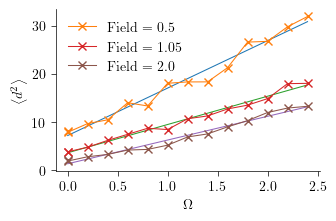

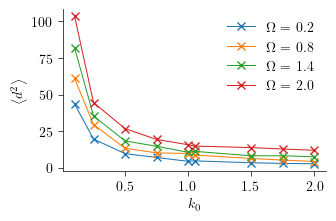

In [12]:
plt.figure(1)
for nField in valid_fields[2::3]:
    slope, intercept, *_ = stats.linregress(inertias[valid_inertias],dsqIsm[valid_inertias,nField])
    plt.plot(inertias[valid_inertias],np.array(inertias[valid_inertias])*slope+intercept)
    plt.plot(inertias[valid_inertias],dsqIsm[valid_inertias,nField],'x-',label = 'Field = '+str(fields[nField]))
plt.legend()
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\left< d^2\right>$')
#plt.savefig(extFieldISMImages_dir+"/figdsq.png",format ='png',dpi = 1000, bbox_inches = 'tight',pad_inches= 0.03)

plt.figure(2)
for nChi in valid_inertias[2::3]:
    plt.plot(fields[valid_fields],dsqIsm[nChi,valid_fields],'x-',label = r'$\Omega$ = '+str(inertias[nChi]))
plt.legend()
plt.xlabel(r'$k_0$')
plt.ylabel(r'$\left< d^2\right>$')
#plt.savefig(extFieldISMImages_dir+"/figdsqFields.png",format ='png',dpi = 1000, bbox_inches = 'tight',pad_inches= 0.03)




## Correlation times